# Optimal Growth I: The Stochastic Optimal Growth Model

## Contents

- [Optimal Growth I: The Stochastic Optimal Growth Model](#Optimal-Growth-I:-The-Stochastic-Optimal-Growth-Model)  
  - [Overview](#Overview)  
  - [The Model](#The-Model)  
  - [Computation](#Computation)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

## Overview

In this lecture we’re going to study a simple optimal growth model with one agent

The model is a version of the standard one sector infinite horizon growth model studied in

- [[SLP89]](https://lectures.quantecon.org/py/zreferences.html#stokeylucas1989), chapter 2  
- [[LS18]](https://lectures.quantecon.org/py/zreferences.html#ljungqvist2012), section 3.1  
- [EDTC](http://johnstachurski.net/edtc.html), chapter 1  
- [[Sun96]](https://lectures.quantecon.org/py/zreferences.html#sundaram1996), chapter 12  


The technique we use to solve the model is dynamic programming

Our treatment of dynamic programming follows on from earlier
treatments in our lectures on [shortest paths](https://lectures.quantecon.org/py/short_path.html) and
[job search](https://lectures.quantecon.org/py/mccall_model.html)

We’ll discuss some of the technical details of dynamic programming as we
go along

Let’s start with some imports

We use an interpolation function from the
[interpolation.py package](https://github.com/EconForge/interpolation.py)
because it comes in handy later when we want to just-in-time compile our code

This library can be installed with the following command in Jupyter: `!pip install interpolation`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from interpolation import interp
from numba import njit, prange
from quantecon.optimize.scalar_maximization import brent_max

## The Model


<a id='index-1'></a>
Consider an agent who owns an amount $ y_t \in \mathbb R_+ := [0, \infty) $ of a consumption good at time $ t $

This output can either be consumed or invested

When the good is invested it is transformed one-for-one into capital

The resulting capital stock, denoted here by $ k_{t+1} $, will then be used for production

Production is stochastic, in that it also depends on a shock $ \xi_{t+1} $ realized at the end of the current period

Next period output is

$$
y_{t+1} := f(k_{t+1}) \xi_{t+1}
$$

where $ f \colon \mathbb R_+ \to \mathbb R_+ $ is called the production function

The resource constraint is


<a id='equation-outcsdp0'></a>
$$
k_{t+1} + c_t \leq y_t \tag{1}
$$

and all variables are required to be nonnegative

### Assumptions and Comments

In what follows,

- The sequence $ \{\xi_t\} $ is assumed to be IID  
- The common distribution of each $ \xi_t $ will be denoted $ \phi $  
- The production function $ f $ is assumed to be increasing and continuous  
- Depreciation of capital is not made explicit but can be incorporated into the production function  


While many other treatments of the stochastic growth model use $ k_t $ as the state variable, we will use $ y_t $

This will allow us to treat a stochastic model while maintaining only one state variable

We consider alternative states and timing specifications in some of our other lectures

### Optimization

Taking $ y_0 $ as given, the agent wishes to maximize


<a id='equation-texs0-og2'></a>
$$
\mathbb E \left[ \sum_{t = 0}^{\infty} \beta^t u(c_t) \right] \tag{2}
$$

subject to


<a id='equation-og-conse'></a>
$$
y_{t+1} = f(y_t - c_t) \xi_{t+1}
\quad \text{and} \quad
0 \leq c_t \leq y_t
\quad \text{for all } t \tag{3}
$$

where

- $ u $ is a bounded, continuous and strictly increasing utility function and  
- $ \beta \in (0, 1) $ is a discount factor  


In [(3)](#equation-og-conse) we are assuming that the resource constraint [(1)](#equation-outcsdp0) holds with equality — which is reasonable because $ u $ is strictly increasing and no output will be wasted at the optimum

In summary, the agent’s aim is to select a path $ c_0, c_1, c_2, \ldots $ for consumption that is

1. nonnegative,  
1. feasible in the sense of [(1)](#equation-outcsdp0),  
1. optimal, in the sense that it maximizes [(2)](#equation-texs0-og2) relative to all other feasible consumption sequences, and  
1. *adapted*, in the sense that the action $ c_t $ depends only on
  observable outcomes, not future outcomes such as $ \xi_{t+1} $  


In the present context

- $ y_t $ is called the *state* variable — it summarizes the “state of the world” at the start of each period  
- $ c_t $ is called the *control* variable — a value chosen by the agent each period after observing the state  

### The Policy Function Approach


<a id='index-2'></a>
One way to think about solving this problem is to look for the best **policy function**

A policy function is a map from past and present observables into current action

We’ll be particularly interested in **Markov policies**, which are maps from the current state $ y_t $ into a current action $ c_t $

For dynamic programming problems such as this one (in fact for any [Markov decision process](https://en.wikipedia.org/wiki/Markov_decision_process)), the optimal policy is always a Markov policy

In other words, the current state $ y_t $ provides a sufficient statistic
for the history in terms of making an optimal decision today

This is quite intuitive but if you wish you can find proofs in texts such as [[SLP89]](https://lectures.quantecon.org/py/zreferences.html#stokeylucas1989) (section 4.1)

Hereafter we focus on finding the best Markov policy

In our context, a Markov policy is a function $ \sigma \colon
\mathbb R_+ \to \mathbb R_+ $, with the understanding that states are mapped to actions via

$$
c_t = \sigma(y_t) \quad \text{for all } t
$$

In what follows, we will call $ \sigma $ a *feasible consumption policy* if it satisfies


<a id='equation-idp-fp-og2'></a>
$$
0 \leq \sigma(y) \leq y
\quad \text{for all} \quad
y \in \mathbb R_+ \tag{4}
$$

In other words, a feasible consumption policy is a Markov policy that respects the resource constraint

The set of all feasible consumption policies will be denoted by $ \Sigma $

Each $ \sigma \in \Sigma $ determines a [continuous state Markov process](https://lectures.quantecon.org/py/stationary_densities.html) $ \{y_t\} $ for output via


<a id='equation-firstp0-og2'></a>
$$
y_{t+1} = f(y_t - \sigma(y_t)) \xi_{t+1},
\quad y_0 \text{ given} \tag{5}
$$

This is the time path for output when we choose and stick with the policy $ \sigma $

We insert this process into the objective function to get


<a id='equation-texss'></a>
$$
\mathbb E
\left[ \,
\sum_{t = 0}^{\infty} \beta^t u(c_t) \,
\right] =
\mathbb E
\left[ \,
\sum_{t = 0}^{\infty} \beta^t u(\sigma(y_t)) \,
\right] \tag{6}
$$

This is the total expected present value of following policy $ \sigma $ forever,
given initial income $ y_0 $

The aim is to select a policy that makes this number as large as possible

The next section covers these ideas more formally

### Optimality

The $ \sigma`**-value function** :math:`v_{\sigma} $ associated with a given policy $ \sigma $ is the mapping defined by


<a id='equation-vfcsdp00'></a>
$$
v_{\sigma}(y) =
\mathbb E \left[ \sum_{t = 0}^{\infty} \beta^t u(\sigma(y_t)) \right] \tag{7}
$$

when $ \{y_t\} $ is given by [(5)](#equation-firstp0-og2) with $ y_0 = y $

In other words, it is the lifetime value of following policy $ \sigma $
starting at initial condition $ y $

The **value function** is then defined as


<a id='equation-vfcsdp0'></a>
$$
v^*(y) := \sup_{\sigma \in \Sigma} \; v_{\sigma}(y) \tag{8}
$$

The value function gives the maximal value that can be obtained from state $ y $, after considering all feasible policies

A policy $ \sigma \in \Sigma $ is called **optimal** if it attains the supremum in [(8)](#equation-vfcsdp0) for all $ y \in \mathbb R_+ $

### The Bellman Equation

With our assumptions on utility and production function, the value function as defined in [(8)](#equation-vfcsdp0) also satisfies a **Bellman equation**

For this problem, the Bellman equation takes the form


<a id='equation-fpb30'></a>
$$
v(y) = \max_{0 \leq c \leq y}
    \left\{
        u(c) + \beta \int v(f(y - c) z) \phi(dz)
    \right\}
\qquad (y \in \mathbb R_+) \tag{9}
$$

This is a *functional equation in* $ v $

The term $ \int v(f(y - c) z) \phi(dz) $ can be understood as the expected next period value when

- $ v $ is used to measure value  
- the state is $ y $  
- consumption is set to $ c $  


As shown in [EDTC](http://johnstachurski.net/edtc.html), theorem 10.1.11 and a range of other texts

> *The value function* $ v^* $ *satisfies the Bellman equation*


In other words, [(9)](#equation-fpb30) holds when $ v=v^* $

The intuition is that maximal value from a given state can be obtained by optimally trading off

- current reward from a given action, vs  
- expected discounted future value of the state resulting from that action  


The Bellman equation is important because it gives us more information about the value function

It also suggests a way of computing the value function, which we discuss below

### Greedy policies

The primary importance of the value function is that we can use it to compute optimal policies

The details are as follows

Given a continuous function $ v $ on $ \mathbb R_+ $, we say that
$ \sigma \in \Sigma $ is $ v $-**greedy** if $ \sigma(y) $ is a solution to


<a id='equation-defgp20'></a>
$$
\max_{0 \leq c \leq y}
    \left\{
    u(c) + \beta \int v(f(y - c) z) \phi(dz)
    \right\} \tag{10}
$$

for every $ y \in \mathbb R_+ $

In other words, $ \sigma \in \Sigma $ is $ v $-greedy if it optimally
trades off current and future rewards when $ v $ is taken to be the value
function

In our setting, we have the following key result

> - A feasible consumption policy is optimal if and only it is $ v^* $-greedy  



The intuition is similar to the intuition for the Bellman equation, which was
provided after [(9)](#equation-fpb30)

See, for example, theorem 10.1.11 of [EDTC](http://johnstachurski.net/edtc.html)

Hence, once we have a good approximation to $ v^* $, we can compute the
(approximately) optimal policy by computing the corresponding greedy policy

The advantage is that we are now solving a much lower dimensional optimization
problem

### The Bellman Operator

How, then, should we compute the value function?

One way is to use the so-called **Bellman operator**

(An operator is a map that sends functions into functions)

The Bellman operator is denoted by $ T $ and defined by


<a id='equation-fcbell20-optgrowth'></a>
$$
Tv(y) := \max_{0 \leq c \leq y}
\left\{
    u(c) + \beta \int v(f(y - c) z) \phi(dz)
\right\}
\qquad (y \in \mathbb R_+) \tag{11}
$$

In other words, $ T $ sends the function $ v $ into the new function
$ Tv $ defined by [(11)](#equation-fcbell20-optgrowth)

By construction, the set of solutions to the Bellman equation
[(9)](#equation-fpb30) *exactly coincides with* the set of fixed points of $ T $

For example, if $ Tv = v $, then, for any $ y \geq 0 $,

$$
v(y)
= Tv(y)
= \max_{0 \leq c \leq y}
\left\{
    u(c) + \beta \int v^*(f(y - c) z) \phi(dz)
\right\}
$$

which says precisely that $ v $ is a solution to the Bellman equation

It follows that $ v^* $ is a fixed point of $ T $

### Review of Theoretical Results


<a id='index-3'></a>
One can also show that $ T $ is a contraction mapping on the set of
continuous bounded functions on $ \mathbb R_+ $ under the supremum distance

$$
\rho(g, h) = \sup_{y \geq 0} |g(y) - h(y)|
$$

See  [EDTC](http://johnstachurski.net/edtc.html), lemma 10.1.18

Hence it has exactly one fixed point in this set, which we know is equal to the value function

It follows that

- The value function $ v^* $ is bounded and continuous  
- Starting from any bounded and continuous $ v $, the sequence $ v, Tv, T^2v, \ldots $
  generated by iteratively applying $ T $ converges uniformly to $ v^* $  


This iterative method is called **value function iteration**

We also know that a feasible policy is optimal if and only if it is $ v^* $-greedy

It’s not too hard to show that a $ v^* $-greedy policy exists
(see  [EDTC](http://johnstachurski.net/edtc.html), theorem 10.1.11 if you get stuck)

Hence at least one optimal policy exists

Our problem now is how to compute it

### Unbounded Utility


<a id='index-5'></a>
The results stated above assume that the utility function is bounded

In practice economists often work with unbounded utility functions — and so will we

In the unbounded setting, various optimality theories exist

Unfortunately, they tend to be case specific, as opposed to valid for a large range of applications

Nevertheless, their main conclusions are usually in line with those stated for
the bounded case just above (as long as we drop the word “bounded”)

Consult,  for example, section 12.2 of [EDTC](http://johnstachurski.net/edtc.html), [[Kam12]](https://lectures.quantecon.org/py/zreferences.html#kamihigashi2012) or [[MdRV10]](https://lectures.quantecon.org/py/zreferences.html#mv2010)

## Computation


<a id='index-6'></a>
Let’s now look at computing the value function and the optimal policy

### Fitted Value Iteration


<a id='index-7'></a>
The first step is to compute the value function by value function iteration

In theory, the algorithm is as follows

1. Begin with a function $ v $ — an initial condition  
1. Solving [(11)](#equation-fcbell20-optgrowth), obtain the function $ Tv $  
1. Unless some stopping condition is satisfied, set $ v = Tv $ and go to step 2  


This generates the sequence $ v, Tv, T^2v, \ldots $

However, there is a problem we must confront before we implement this procedure:
The iterates can neither be calculated exactly nor stored on a computer

To see the issue, consider [(11)](#equation-fcbell20-optgrowth)

Even if $ v $ is a known function, unless $ Tv $ can be shown to have
some special structure, the only way to store it is to record the
value $ Tv(y) $ for every $ y \in \mathbb R_+ $

Clearly this is impossible

What we will do instead is use **fitted value function iteration**

The procedure is to record the value of the function $ Tv $ at only
finitely many “grid” points $ y_1 < y_2 < \cdots < y_I $ and reconstruct it from this information when required

More precisely, the algorithm will be


<a id='fvi-alg'></a>
1. Begin with an array of values $ \{ v_1, \ldots, v_I \} $ representing
  the values of some initial function $ v $ on the grid points $ \{ y_1, \ldots, y_I \} $  
1. Build a function $ \hat v $ on the state space $ \mathbb R_+ $ by
  interpolation or approximation, based on these data points  
1. Obtain and record the value $ T \hat v(y_i) $ on each grid point
  $ y_i $ by repeatedly solving [(11)](#equation-fcbell20-optgrowth)  
1. Unless some stopping condition is satisfied, set
  $ \{ v_1, \ldots, v_I \} = \{ T \hat v(y_1), \ldots, T \hat v(y_I) \} $ and go to step 2  


How should we go about step 2?

This is a problem of function approximation, and there are many ways to approach it

What’s important here is that the function approximation scheme must not only
produce a good approximation to $ Tv $, but also combine well with the broader iteration algorithm described above

One good choice from both respects is continuous piecewise linear interpolation (see <a href=/_static/pdfs/3ndp.pdf download>this paper</a> for further discussion)

The next figure illustrates piecewise linear interpolation of an arbitrary
function on grid points $ 0, 0.2, 0.4, 0.6, 0.8, 1 $

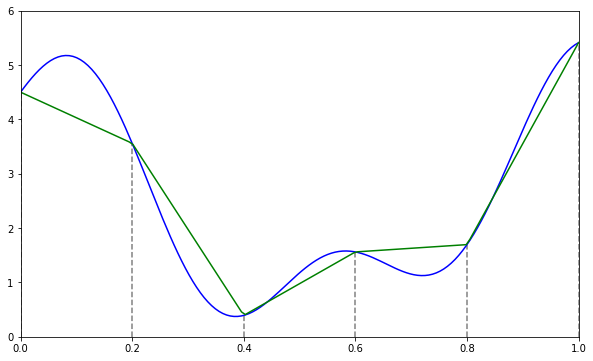

In [2]:
def f(x):
    y1 = 2 * np.cos(6 * x) + np.sin(14 * x)
    return y1 + 2.5

def Af(x):
    return interp(c_grid, f(c_grid), x)

c_grid = np.linspace(0, 1, 6)
f_grid = np.linspace(0, 1, 150)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(f_grid, f(f_grid), 'b-', label='true function')
ax.plot(f_grid, Af(f_grid), 'g-', label='linear approximation')
ax.vlines(c_grid, c_grid * 0, f(c_grid), linestyle='dashed', alpha=0.5)

ax.set(xlim=(0, 1), ylim=(0, 6))
plt.show()

Another advantage of piecewise linear interpolation is that it preserves
useful shape properties such as monotonicity and concavity / convexity

### Optimal Growth Model

We will hold the primitives of the optimal growth model in a class

The distribution $ \phi $ of the shock is assumed to be lognormal,
and so a draw from $ \exp(\mu + \sigma \zeta) $ when $ \zeta $ is standard normal

In [3]:
class OptimalGrowthModel:

    def __init__(self,
                 f,                # Production function
                 u,                # Utility function
                 β=0.96,           # Discount factor
                 μ=0,
                 s=0.1,
                 grid_max=4,
                 grid_size=200,
                 shock_size=250):

        self.β, self.μ, self.s = β, μ, s
        self.f, self.u = f, u

        self.y_grid = np.linspace(1e-5, grid_max, grid_size)       # Set up grid
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))  # Store shocks

### The Bellman Operator

Here’s a function that generates a Bellman operator using linear interpolation

In [4]:
def operator_factory(og, parallel_flag=True):
    """
    A function factory for building the Bellman operator, as well as
    a function that computes greedy policies.
    
    Here og is an instance of OptimalGrowthModel.
    """

    f, u, β = og.f, og.u, og.β
    y_grid, shocks = og.y_grid, og.shocks

    @njit
    def objective(c, v, y):
        """
        The right hand side of the Bellman equation
        """
        # First turn v into a function via interpolation
        v_func = lambda x: interp(y_grid, v, x)
        return u(c) + β * np.mean(v_func(f(y - c) * shocks))

    @njit(parallel=parallel_flag)
    def T(v):
        """
        The Bellman operator
        """
        v_new = np.empty_like(v)
        for i in prange(len(y_grid)):
            y = y_grid[i]
            # Solve for optimal v at y
            v_max = brent_max(objective, 1e-10, y, args=(v, y))[1]  
            v_new[i] = v_max
        return v_new

    @njit
    def get_greedy(v):
        """
        Computes the v-greedy policy of a given function v
        """
        σ = np.empty_like(v)
        for i in range(len(y_grid)):
            y = y_grid[i]
            # Solve for optimal c at y
            c_max = brent_max(objective, 1e-10, y, args=(v, y))[0]  
            σ[i] = c_max
        return σ

    return T, get_greedy

The function `operator_factory` takes a class that represents the growth model,
and returns the operator `T` and a function `get_greedy` that we will use to solve the model

Notice that the expectation in [(11)](#equation-fcbell20-optgrowth) is computed via Monte Carlo, using the approximation

$$
\int v(f(y - c) z) \phi(dz) \approx \frac{1}{n} \sum_{i=1}^n v(f(y - c) \xi_i)
$$

where $ \{\xi_i\}_{i=1}^n $ are IID draws from $ \phi $

Monte Carlo is not always the most efficient way to compute integrals numerically
but it does have some theoretical advantages in the present setting

(For example, it preserves the contraction mapping property of the Bellman operator — see, e.g., [[PalS13]](https://lectures.quantecon.org/py/zreferences.html#pal2013))


<a id='benchmark-growth-mod'></a>

### An Example

Let’s test out our operator when

- $ f(k) = k^{\alpha} $  
- $ u(c) = \ln c $  
- $ \phi $ is the distribution of $ \exp(\mu + \sigma \zeta) $ when $ \zeta $ is standard normal  


As is well-known (see [[LS18]](https://lectures.quantecon.org/py/zreferences.html#ljungqvist2012), section 3.1.2), for this particular problem an exact analytical solution is available, with


<a id='equation-dpi-tv'></a>
$$
v^*(y) =
\frac{\ln (1 - \alpha \beta) }{ 1 - \beta} +
\frac{(\mu + \alpha \ln (\alpha \beta))}{1 - \alpha}
 \left[
     \frac{1}{1- \beta} - \frac{1}{1 - \alpha \beta}
 \right] +
 \frac{1}{1 - \alpha \beta} \ln y \tag{12}
$$

The optimal consumption policy is

$$
\sigma^*(y) = (1 - \alpha \beta ) y
$$

We will define functions to compute the closed form solutions to check our answers

In [5]:
def σ_star(y, α, β):
    """
    True optimal policy
    """
    return (1 - α * β) * y

def v_star(y, α, β, μ):
    """
    True value function
    """
    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)
    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

### A First Test

To test our code, we want to see if we can replicate the analytical solution
numerically, using fitted value function iteration

First, having run the code for the general model shown above, let’s
generate an instance of the model and generate its Bellman operator

We first need to define a jitted version of the production function

In [6]:
α = 0.4  # Production function parameter

@njit
def f(k):
    """
    Cobb-Douglas production function
    """
    return k**α

Now we will create an instance of the model and assign it to the variable `og`

This instance will use the Cobb-Douglas production function and log utility

In [7]:
og = OptimalGrowthModel(f=f, u=np.log)

We will use `og` to generate the Bellman operator and a function that computes
greedy policies

In [8]:
T, get_greedy = operator_factory(og)

Now let’s do some tests

As one preliminary test, let’s see what happens when we apply our Bellman operator to the exact solution $ v^* $

In theory, the resulting function should again be $ v^* $

In practice we expect some small numerical error

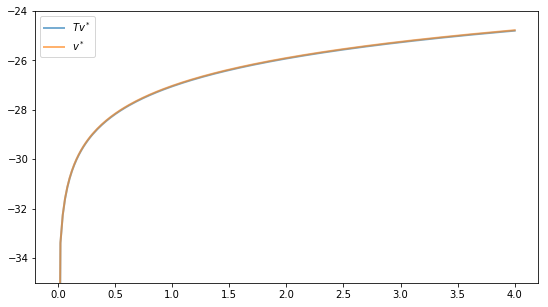

In [9]:
y_grid = og.y_grid
β, μ = og.β, og.μ

v_init = v_star(y_grid, α, β, μ)  # Start at the solution
v = T(v_init)                     # Apply the Bellman operator once

fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(-35, -24)
ax.plot(y_grid, v, lw=2, alpha=0.6, label='$Tv^*$')
ax.plot(y_grid, v_init, lw=2, alpha=0.6, label='$v^*$')
ax.legend()
plt.show()

The two functions are essentially indistinguishable, so we are off to a good start

Now let’s have a look at iterating with the Bellman operator, starting off
from an arbitrary initial condition

The initial condition we’ll start with is $ v(y) = 5 \ln (y) $

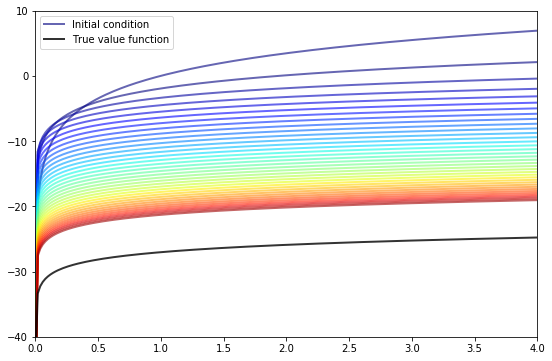

In [10]:
v = 5 * np.log(y_grid)  # An initial condition
n = 35

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(y_grid, v, color=plt.cm.jet(0),
        lw=2, alpha=0.6, label='Initial condition')

for i in range(n):
    v = T(v)  # Apply the Bellman operator
    ax.plot(y_grid, v, color=plt.cm.jet(i / n), lw=2, alpha=0.6)

ax.plot(y_grid, v_star(y_grid, α, β, μ), 'k-', lw=2,
        alpha=0.8, label='True value function')

ax.legend()
ax.set(ylim=(-40, 10), xlim=(np.min(y_grid), np.max(y_grid)))
plt.show()

The figure shows

1. the first 36 functions generated by the fitted value function iteration algorithm, with hotter colors given to higher iterates  
1. the true value function $ v^* $ drawn in black  


The sequence of iterates converges towards $ v^* $

We are clearly getting closer

We can write a function that iterates until the difference is below a particular
tolerance level

In [11]:
def solve_model(og,
                use_parallel=True,
                tol=1e-4, 
                max_iter=1000, 
                verbose=True,
                print_skip=25): 

    T, _ = operator_factory(og, parallel_flag=use_parallel)

    # Set up loop
    v = np.log(og.y_grid)  # Initial condition
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if i == max_iter: 
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")
        
    return v_new

We can check our result by plotting it against the true value

Error at iteration 25 is 0.4197567955061814.
Error at iteration 50 is 0.15127389204752006.


Error at iteration 75 is 0.054518614036435764.
Error at iteration 100 is 0.01964832950647022.


Error at iteration 125 is 0.007081193445895195.
Error at iteration 150 is 0.0025520388693536233.


Error at iteration 175 is 0.000919746429872248.
Error at iteration 200 is 0.00033147359368967955.


Error at iteration 225 is 0.00011946199496293275.

Converged in 230 iterations.


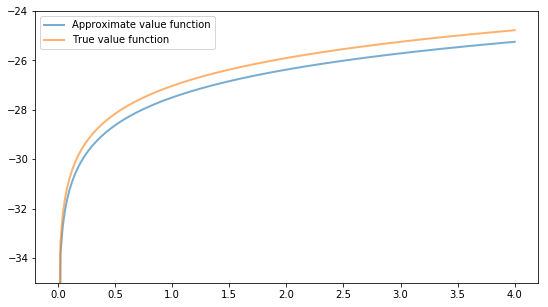

In [12]:
v_solution = solve_model(og)

fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(y_grid, v_solution, lw=2, alpha=0.6,
        label='Approximate value function')

ax.plot(y_grid, v_star(y_grid, α, β, μ), lw=2,
        alpha=0.6, label='True value function')

ax.legend()
ax.set_ylim(-35, -24)
plt.show()

The figure shows that we are pretty much on the money

### The Policy Function


<a id='index-8'></a>
To compute an approximate optimal policy, we will use the second function
returned from `operator_factory` that backs out the optimal policy
from the solution to the Bellman equation

The next figure compares the result to the exact solution, which, as mentioned
above, is $ \sigma(y) = (1 - \alpha \beta) y $

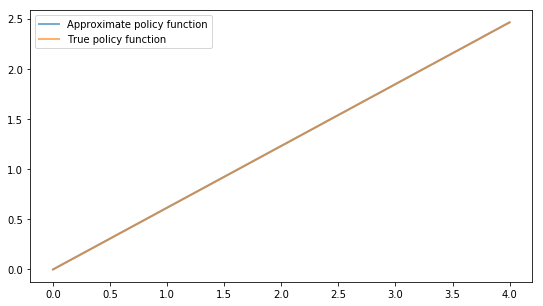

In [13]:
fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(y_grid, get_greedy(v_solution), lw=2,
        alpha=0.6, label='Approximate policy function')

ax.plot(y_grid, σ_star(y_grid, α, β),
        lw=2, alpha=0.6, label='True policy function')

ax.legend()
plt.show()

The figure shows that we’ve done a good job in this instance of approximating
the true policy

## Exercises

### Exercise 1

Once an optimal consumption policy $ \sigma $ is given, income follows [(5)](#equation-firstp0-og2)

The next figure shows a simulation of 100 elements of this sequence for three
different discount factors (and hence three different policies)

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/solution_og_ex2.png" style="width:60%;height:60%">

  
In each sequence, the initial condition is $ y_0 = 0.1 $

The discount factors are `discount_factors = (0.8, 0.9, 0.98)`

We have also dialed down the shocks a bit with `s = 0.05`

Otherwise, the parameters and primitives are the same as the log linear model discussed earlier in the lecture

Notice that more patient agents typically have higher wealth

Replicate the figure modulo randomness

## Solutions

### Exercise 1

Here’s one solution (assuming as usual that you’ve executed everything above)

In [14]:
def simulate_og(σ_func, og, α, y0=0.1, ts_length=100):
    '''
    Compute a time series given consumption policy σ.
    '''
    y = np.empty(ts_length)
    ξ = np.random.randn(ts_length-1)
    y[0] = y0
    for t in range(ts_length-1):
        y[t+1] = (y[t] - σ_func(y[t]))**α * np.exp(og.μ + og.s * ξ[t])
    return y

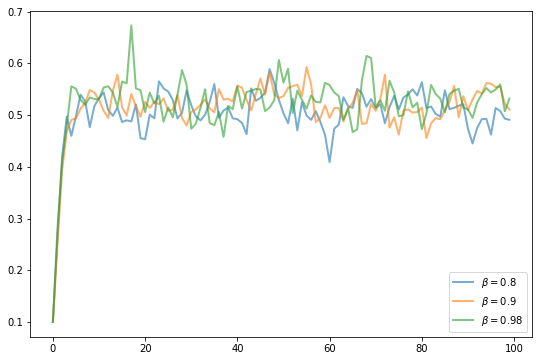

In [15]:
fig, ax = plt.subplots(figsize=(9, 6))

for β in (0.8, 0.9, 0.98):

    og = OptimalGrowthModel(f, np.log, β=β, s=0.05)
    y_grid = og.y_grid

    v_solution = solve_model(og, verbose=False)

    σ_star = get_greedy(v_solution)
    σ_func = lambda x: interp(y_grid, σ_star, x)  # Define an optimal policy function
    y = simulate_og(σ_func, og, α)
    ax.plot(y, lw=2, alpha=0.6, label=rf'$\beta = {β}$')

ax.legend(loc='lower right')
plt.show()